In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [309]:
def calc_gauss(x, e, x0, s):
    return e * np.exp(-(x-x0)**2/s**2) / 1000

def calc_profile(ngauss, nstates, svalues, evalues):
    RT = 1.987*298.
    xvalues = (0, nstates - 1)
    xmin = 0.
    xmax = float(nstates - 1)
    
    
    random.seed()
    gauss = []
    for st in range(ngauss):
        gauss.append({
            'x' : random.randrange(xvalues[0], xvalues[1]),
            's' : random.randrange(svalues[0], svalues[1]),
            'e' : random.randrange(evalues[0], evalues[1])
        })

    # Preparing the Wall functions
    wall_s = 0.1 * xmax
    wall_ef = 0.1 * ngauss
    
    gauss.append({'x' : xmin, 's' : wall_s, 'e': wall_ef * evalues[1]})
    gauss.append({'x' : xmax, 's' : wall_s, 'e': wall_ef * evalues[1]})
    
    # Adding the gaussian functions to get the final profi.e
    energy_profile = {}
    for st in range(nstates):
        energy_profile[st] = 0.
        for gss in gauss:
            energy_profile[st] += calc_gauss(float(st), RT * gss['e'], gss['x'], gss['s'])
    
    return energy_profile

def calc_boltzmann_term(e, T):
    R = 1.987
    return np.exp(-e/R/T)


### Prep energy profile

Prepared as a sum of random gaussian functions. Nstates define the x range (0, nstates-1), ngauss the number of Gaussian functions, evalues the range of energies and s the range of std. deviations.
Two additional functions are added at the ends of the range to give "funnel" shape to the landscape

In [326]:
nstates = 100
ngauss = 500
evalues = (20, 80)
svalues = (2 , 10)


In [327]:
energy_profile = calc_profile(ngauss, nstates, svalues, evalues)

In [328]:
e_prof = np.array([np.linspace(xmin, xmax, num=nstates), list(energy_profile.values())])
np.save('e_profile', e_prof)

In [329]:
e_prof = np.load('e_profile.npy')

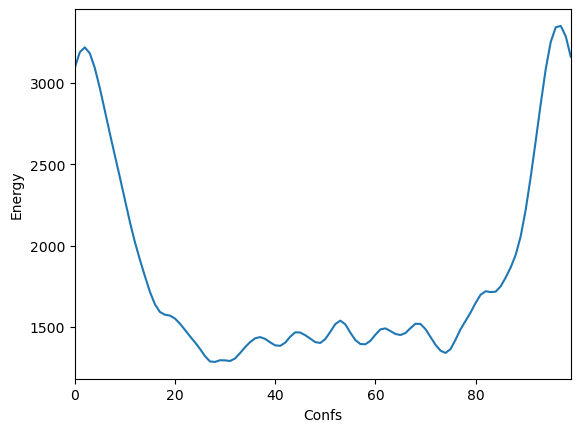

In [330]:
fig, ax = plt.subplots()
ax.plot(e_prof[0], e_prof[1])
ax.set_xlim(left=xmin, right=xmax)
ax.set_ylabel('Energy')
ax.set_xlabel('Confs')
plt.show()


In [ ]:
T = 100
boltz = {}
total_boltz = 0.
for st in energy_profile:
    boltz[st] = calc_boltzmann_term(energy_profile[st], T)
    total_boltz += boltz[st]
for st in boltz:
    boltz[st] /= total_boltz
btz_prof = np.array([np.linspace(xmin, xmax, num=nstates), list(boltz.values())])

acc_btz = {}
acc_btz[0] = boltz[0]
for st in range(1, nstates):
    acc_btz[st] = acc_btz[st - 1] + boltz[st]
acc_btz_prof = np.array([np.linspace(xmin, xmax, num=nstates), list(acc_btz.values())])


In [507]:
fig, ax = plt.subplots()
ax.set_ylabel('Energy')
ax.set_xlabel('Confs')
ax2 = ax.twinx()
ax.plot(e_prof[0], e_prof[1], label="Epot")
ax.set_xlim(left=xmin + 10, right=xmax-10)
ax2.plot(btz_prof[0], btz_prof[1], label="Rel.Pop", color="red")
ax2.set_ylabel("Relative population")
plt.legend(loc='upper left')
plt.show()


In [511]:
def get_energy_bin(acc_btz_prof, rn):
        st = 0
        while acc_btz_prof[st] < rn:
            st +=1
        return st



In [514]:
%matplotlib

import matplotlib.animation as animation

maxnparts = 10000
dt = 0.001

pop = {b:0. for b in range(nstates)}

fig, ax = plt.subplots(2,1)

ax[0].set_ylabel('Energy')
ax[0].set_xlabel('Confs')
ax[0].set_xlim(left=xmin + 10, right=xmax-10)
ax[0].plot(e_prof[0], e_prof[1])
ax_xmin, ax_xmax, ax_ymin, ax_ymax = ax[0].axis()

ax2 = ax[0].twinx()
ax2.set_ylabel("Relative population")
ax2.plot(btz_prof[0], btz_prof[1], color="red")
ax2_xmin, ax2_xmax, ax2_ymin, ax2_ymax = ax2.axis()
ax3 = ax[0].twinx()

e_x = [energy_profile[b] for b in range(nstates)], 
        
for nparticles in range(maxnparts):
    b = get_energy_bin(acc_btz, random.random())
    pop[b] += 1
    ax3.clear()
    ax3.set_ylim(ymin=ax2_ymin, ymax=ax2_ymax)
    ax3.scatter(
        btz_prof[0], 
        [pop[b]/(maxnparts + 1) for b in range(nstates)],
        marker='.'
    )
    ax[1].clear()
    ax[1].set_xlabel('Energy')
    ax[1].set_ylabel('Norm. Population')
    ax[1].set_xlim(left=ax_ymin, right=ax_ymax)
    ax[1].set_ylim(ymin=ax2_ymin, ymax=ax2_ymax)
    ax[1].scatter(
        e_x, 
        [pop[b]/(maxnparts + 1) for b in range(nstates)],
        marker='.'
    )
    ax[0].set_title(f"Num. particles: {nparticles}")
    plt.pause(dt)

plt.show()


Using matplotlib backend: QtAgg


KeyboardInterrupt: 